# About this notebook
- tokenizer(anchor[SEP]target | CPC)
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

# Directory settings

In [1]:
# ====================================================
# Directory settings
# ====================================================
comp_name = 'us-patent-phrase-to-phrase-matching'
nb_name = 'nb005t-deberta-v3-large'

import sys
print(sys.version)
if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount("/content/drive")
    base = f"/content/drive/MyDrive/colab_notebooks/kaggle/{comp_name}/notebooks"
    %cd {base}


import os
INPUT_DIR = f'../input/{comp_name}/'
if 'kaggle_web_client' in sys.modules:
    OUTPUT_DIR = './'
else:
    OUTPUT_DIR = f'../input/{nb_name}/'
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/colab_notebooks/kaggle/us-patent-phrase-to-phrase-matching/notebooks


# CFG

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    wandb=True
    wandbproject=comp_name
    wandbgroup=nb_name
    wandbname='late001'
    _wandb_kernel='riow1983'
    apex=True
    print_freq=100
    num_workers=8
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=4
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    #### AWP
    adv_lr=1e-6
    adv_eps=1e-3
    #### AWPAWP
    n_fold=10
    trn_fold=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]
    CFG.wandb = False

In [3]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    if 'google.colab' in sys.modules:
        !pip install wandb
    import wandb

    try:
        if 'kaggle_web_client' in sys.modules:
            from kaggle_secrets import UserSecretsClient
            user_secrets = UserSecretsClient()
            secret_value_0 = user_secrets.get_secret("wandb_api")
        else:
            import json
            f = open("../../wandb.json", "r")
            json_data = json.load(f)
            secret_value_0 = json_data["wandb_api"]
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))
    
    run = wandb.init(
        dir=OUTPUT_DIR,
        project=CFG.wandbproject,
        group=CFG.wandbgroup,
        name=CFG.wandbname, 
        config=class2dict(CFG),
        job_type="train",
        anonymous=anony)
    print(f"wandb run id: {run.id}")

# Library

In [4]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold


# # PyTorchのバージョンを1.10.1に下げる (Google Colabなのでpipでやる)
# os.system('pip uninstall -y torch torchvision torchaudio')
# os.system('pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 torchaudio==0.10.1 -f https://download.pytorch.org/whl/torch_stable.html')


import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
# os.system('python -m pip install transformers')
# os.system('python -m pip install tokenizers')
os.system('pip install sentencepiece')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [5]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [6]:
# ====================================================
# Data Loading
# ====================================================
# #### AUG
# # train = pd.read_csv(INPUT_DIR+'train.csv')
# train = pd.read_csv('../input/kagglenb006-back-translate-aug-data/train.csv')
# #### AUGAUG
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [7]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}

    # for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
    #     with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
    #         s = f.read()
    #     pattern = f'{cpc}\t\t.+'
    #     result = re.findall(pattern, s)
    #     cpc_result = result[0].lstrip(pattern)
    #     for context in [c for c in contexts if c[0] == cpc]:
    #         pattern = f'{context}\t\t.+'
    #         result = re.findall(pattern, s)
    #         results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    
    # Credits to https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/discussion/324928
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        pattern = "^"+pattern[:-2]
        cpc_result = re.sub(pattern, "", result[0])
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            pattern = "^"+pattern[:-2]
            results[context] = cpc_result + ". " + re.sub(pattern, "", result[0])

    
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [8]:
# train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
# test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']

#### SOL11
# train['text'] = train['anchor'] + '[SEP]' + train['target']
# test['text'] = test['anchor'] + '[SEP]' + test['target']

# train['text2'] = train['context_text']
# test['text2'] = test['context_text']

train['group'] = train['context'] + " " + train['anchor']
allres = {}
for text in tqdm(train["group"].unique()):
  tmpdf = train[train["group"]==text].reset_index(drop=True)
  texts = ",".join(tmpdf["target"])
  allres[text] = texts
train["target_gp"] = train["group"].map(allres)
train["text"] = train['anchor'] + "[SEP]" + train['target'] + "[SEP]" + train['context_text'] + "[SEP]" + train['target_gp']

test['group'] = test['context'] + " " + test['anchor']
allres = {}
for text in tqdm(test["group"].unique()):
  tmpdf = test[test["group"]==text].reset_index(drop=True)
  texts = ",".join(tmpdf["target"])
  allres[text] = texts
test["target_gp"] = test["group"].map(allres)
test["text"] = test['anchor'] + "[SEP]" + test['target'] + "[SEP]" + test['context_text'] + "[SEP]" + test['target_gp']
#### SOL11SOL11

display(train.head())
display(test.head())

  0%|          | 0/1699 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

,id,anchor,target,context,score,context_text,group,target_gp,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,A47 abatement,"abatement of pollution,act of abating,active c...",abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,A47 abatement,"abatement of pollution,act of abating,active c...",abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,A47 abatement,"abatement of pollution,act of abating,active c...",abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,A47 abatement,"abatement of pollution,act of abating,active c...",abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,A47 abatement,"abatement of pollution,act of abating,active c...",abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,group,target_gp,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,G02 opc drum,inorganic photoconductor drum,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,F23 adjust gas flow,altering gas flow,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,B60 lower trunnion,lower locating,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,D06 cap component,upper portion,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,H04 neural stimulation,artificial neural network,neural stimulation[SEP]artificial neural netwo...


# EDA

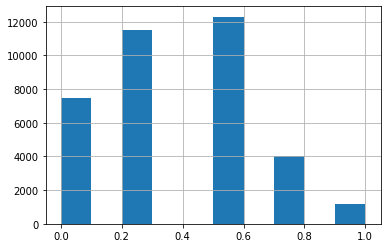

In [9]:
train['score'].hist()

In [10]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [11]:
# ====================================================
# CV split
# ====================================================
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
# Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# display(train.groupby('fold').size())


# #### AUG
# aug = train[train['is_aug']==1].reset_index(drop=True)
# train = train[train['is_aug']==0].reset_index(drop=True)
# #### AUGAUG


# Credits to https://www.kaggle.com/code/hannes82/pppm-deberta-v3-large-closing-the-cv-lb-gap/notebook#CV-split
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
del dfx



# #### AUG
# res = []
# for fold in range(CFG.n_fold):
#     val_ids = train.loc[train['fold']==fold, 'id'].values
#     to_add_aug = aug[~aug['id'].isin(val_ids)].reset_index(drop=True)
#     to_add_aug['fold'] = fold+10
#     res.append(to_add_aug)

# to_add_aug = pd.concat(res, axis=0, ignore_index=True)
# train = pd.concat([train, to_add_aug], axis=0, ignore_index=True)
# del aug, to_add_aug, res, val_ids
# #### AUGAUG

print(train.fold.value_counts())

660 73
660 73
659 74
659 74
660 73
659 74
660 73
660 73
660 73
660 73
0    3954
9    3947
4    3902
6    3647
1    3634
3    3604
2    3524
5    3517
8    3487
7    3257
Name: fold, dtype: int64


In [12]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

fold
0    3954
1    3634
2    3524
3    3604
4    3902
5    3517
6    3647
7    3257
8    3487
9    3947
dtype: int64

fold
0     96
1     97
2    103
3    110
4    120
5    105
6     97
7     87
8     91
9     94
dtype: int64

# tokenizer

In [13]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [14]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

#### SOL11
# train["text"] = train['anchor'] + "[SEP]" + train['target'] + "[SEP]" + train['context_text'] + "[SEP]" + train['target_gp']
# for text_col in ['anchor', 'target']:
for text_col in ['anchor', 'target', 'target_gp']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
# CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
#                 + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP

CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + max(lengths_dict['target_gp']) + 5 # CLS + SEP + SEP + SEP + SEP

#### SOL11SOL11

# CFG.max_len = max(max(lengths_dict['anchor'])+max(lengths_dict['target'])+3, max(lengths_dict['context_text'])+2)
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

max_len: 496


In [15]:
# ====================================================
# Dataset
# ====================================================

#### SOL11
# def prepare_input(cfg, text, text2):
#     inputs = cfg.tokenizer(text, text2,
#                            add_special_tokens=True,
#                            max_length=cfg.max_len,
#                            padding="max_length",
#                            return_offsets_mapping=False)
#     for k, v in inputs.items():
#         inputs[k] = torch.tensor(v, dtype=torch.long)
#     return inputs

def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs
#### SOL11SOL11


#### SOL11
# class TrainDataset(Dataset):
#     def __init__(self, cfg, df):
#         self.cfg = cfg
#         self.texts = df['text'].values
#         self.texts2 = df['text2'].values
#         self.labels = df['score'].values

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, item):
#         inputs = prepare_input(self.cfg, self.texts[item], self.texts2[item])
#         #inputs2 = prepare_input(self.cfg, self.texts2[item])
#         label = torch.tensor(self.labels[item], dtype=torch.float)
#         #return inputs, inputs2, label
#         return inputs, label

class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label
#### SOL11SOL11

In [16]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [17]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        
        # outputs2 = self.model(**inputs2)
        # last_hidden_states2 = outputs2[0]
        
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        #feature2 = torch.mean(last_hidden_states2, dim=1)
        #feature += feature2
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [18]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

#### AWP
#def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, scaler, score, awp):
#### AWPAWP
    model.train()
    # AWP
    #scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    # AWPAWP
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0

    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        # for k, v in inputs2.items():
        #     inputs2[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        #### AWP
        if score > 0.75:
            awp.attack_backward(inputs['input_ids'], labels, inputs['attention_mask'], step) 
        #### AWPAWP

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        # for k, v in inputs2.items():
        #     inputs2[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        # for k, v in inputs[1].items():
        #     inputs[1][k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [19]:
#### AWP
class AWP:
    def __init__(
        self,
        model,
        optimizer,
        adv_param="weight",
        adv_lr=1,
        adv_eps=0.2,
        start_epoch=0,
        adv_step=1,
        scaler=None
    ):
        self.model = model
        self.optimizer = optimizer
        self.adv_param = adv_param
        self.adv_lr = adv_lr
        self.adv_eps = adv_eps
        self.start_epoch = start_epoch
        self.adv_step = adv_step
        self.backup = {}
        self.backup_eps = {}
        self.scaler = scaler

    def attack_backward(self, x, y, attention_mask,epoch):
        if (self.adv_lr == 0) or (epoch < self.start_epoch):
            return None

        self._save() 
        for i in range(self.adv_step):
            self._attack_step() 
            with torch.cuda.amp.autocast():
                adv_loss, tr_logits = self.model(input_ids=x, attention_mask=attention_mask, labels=y)
                adv_loss = adv_loss.mean()
            self.optimizer.zero_grad()
            self.scaler.scale(adv_loss).backward()
            
        self._restore()

    def _attack_step(self):
        e = 1e-6
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                norm1 = torch.norm(param.grad)
                norm2 = torch.norm(param.data.detach())
                if norm1 != 0 and not torch.isnan(norm1):
                    r_at = self.adv_lr * param.grad / (norm1 + e) * (norm2 + e)
                    param.data.add_(r_at)
                    param.data = torch.min(
                        torch.max(param.data, self.backup_eps[name][0]), self.backup_eps[name][1]
                    )
                # param.data.clamp_(*self.backup_eps[name])

    def _save(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                if name not in self.backup:
                    self.backup[name] = param.data.clone()
                    grad_eps = self.adv_eps * param.abs().detach()
                    self.backup_eps[name] = (
                        self.backup[name] - grad_eps,
                        self.backup[name] + grad_eps,
                    )

    def _restore(self,):
        for name, param in self.model.named_parameters():
            if name in self.backup:
                param.data = self.backup[name]
        self.backup = {}
        self.backup_eps = {}

#### AWPAWP

In [20]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    
    # #### AUG
    # train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    # train_folds_aug = train_folds[train_folds['fold']==fold+10].reset_index(drop=True)
    # train_folds_base = train_folds[train_folds['fold']<10].reset_index(drop=True)
    # train_folds = pd.concat([train_folds_base, train_folds_aug], axis=0, ignore_index=True)
    # del train_folds_aug, train_folds_base
    # #### AUGAUG
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)

    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    #### AWP
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    awp = AWP(model,
              optimizer,
              adv_lr=CFG.adv_lr,
              adv_eps=CFG.adv_eps,
              start_epoch=num_train_steps/CFG.epochs,
              scaler=scaler)
    score = 0.
    #### AWPAWP
    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        #### AWP
        #avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, scaler, score, awp)
        #### AWPAWP

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [21]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()




    # Push to LINE
    import requests

    def send_line_notification(message):
        import json
        f = open("../../line.json", "r")
        json_data = json.load(f)
        line_token = json_data["kagglePush"]
        endpoint = 'https://notify-api.line.me/api/notify'
        message = "\n{}".format(message)
        payload = {'message': message}
        headers = {'Authorization': 'Bearer {}'.format(line_token)}
        requests.post(endpoint, data=payload, headers=headers)

    if CFG.wandb:
        send_line_notification(f"Training of {CFG.wandbproject+'/'+CFG.wandbgroup+'/'+CFG.wandbname} has been done. See {run.url}")
    else:
        send_line_notification(f"Training of {CFG.wandbproject+'/'+CFG.wandbgroup+'/'+CFG.wandbname} has been done.")

========== fold: 0 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClas

Epoch: [1][0/150] Elapsed 0m 2s (remain 5m 5s) Loss: 0.6619(0.6619) Grad: inf  LR: 0.00002000  


RuntimeError: ignored